In [1]:
from evals.models.dino import DINO
from evals.models.stablediffusion import DIFT
from evals.models.clip import CLIP
from evals.models.sam import SAM
from evals.models.radio import RADIO

from PIL import Image
import numpy as np
import torch
from torchvision import transforms as transforms
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt

import torch.nn.functional as F
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import torch
from sklearn.decomposition import PCA
import pdb

def PCA_visualize(feature, H, W, return_res=False):

    feature_img_resized = F.interpolate(feature, 
                            size=(H, W), 
                            mode='bilinear', 
                            align_corners=True)
    feature_img_resized = feature_img_resized[0].permute(1, 2, 0)
    feature = feature_img_resized
    if feature.device != torch.device('cpu'):
        feature = feature.cpu()
    pca = PCA(n_components=3)
    tmp_feature = feature.reshape(-1, feature.shape[-1]).detach().numpy()
    pca.fit(tmp_feature)
    pca_feature = pca.transform(tmp_feature)
    for i in range(3): # min_max scaling
        pca_feature[:, i] = (pca_feature[:, i] - pca_feature[:, i].min()) / (pca_feature[:, i].max() - pca_feature[:, i].min())
    pca_feature = pca_feature.reshape(feature.shape[0], feature.shape[1], 3)
    print(pca_feature.shape)
    show_img = Image.fromarray((pca_feature * 255).astype(np.uint8))
    if return_res:
        return pca_feature
    plt.imshow(pca_feature)  # cmap='gray'表示使用灰度颜色映射
    plt.axis('off')
    plt.show()
    
def load_image(url, transform_size):
    img = Image.open(url)
    img = np.array(img)[:, :, :3]
    H, W = img.shape[0], img.shape[1]
    img = Image.fromarray(img)
    rgb_transform = transforms.Compose(
                [
                    transforms.Resize((transform_size, transform_size)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ]
            )
    img = rgb_transform(img).to('cuda')
    img = img.unsqueeze(0).detach()
    return img, H, W

def get_point_cloud(obs):
    camera_params = obs["camera_param"]
    images = obs["image"]
    camera_dicts = camera_params
    for camera_name in camera_dicts:
        if camera_name != 'hand_camera':
            continue
        camera_intrinsic = camera_dicts[camera_name]["intrinsic_cv"]
        cam2world_matrix = camera_dicts[camera_name]["cam2world_gl"]
        Rtilt_rot = cam2world_matrix[:3, :3] @ np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
        Rtilt_trl = cam2world_matrix[:3, 3]
        cam2_wolrd = np.eye(4)
        cam2_wolrd[:3, :3] = Rtilt_rot
        cam2_wolrd[:3, 3] = Rtilt_trl
        camera_dicts[camera_name]["cam2world"] = cam2_wolrd
        camera_image = images[camera_name]
        camera_rgb = camera_image["rgb"]
        camera_depth = camera_image["depth"]
        point_cloud_world, per_point_rgb, = tanslation_point_cloud(camera_depth, camera_rgb,
                                                                                    camera_intrinsic, cam2_wolrd)
            
        camera_dicts[camera_name]["point_cloud_world"] = point_cloud_world
        camera_dicts[camera_name]["per_point_rgb"] = per_point_rgb
        camera_dicts[camera_name]["rgb"] = camera_rgb
        camera_dicts[camera_name]["depth"] = camera_depth
        camera_dicts[camera_name]["camera_intrinsic"] = camera_intrinsic
        # view_point_cloud_parts(point_cloud=point_cloud_world, mask=seg_mask)
        # view_point_cloud_parts(point_cloud=point_cloud_world, rgb=per_point_rgb)
    return camera_dicts

def tanslation_point_cloud(depth_map, rgb_image, camera_intrinsic, cam2world_matrix):
    depth_map = depth_map.reshape(depth_map.shape[0], depth_map.shape[1])
    rows, cols = depth_map.shape[0], depth_map.shape[1]
    
    u, v = np.meshgrid(np.arange(cols), np.arange(rows))
    z = depth_map
    x = (u - camera_intrinsic[0][2]) * z / camera_intrinsic[0][0]
    y = (v - camera_intrinsic[1][2]) * z / camera_intrinsic[1][1]
    points = np.dstack((x, y, z))
    per_point_xyz = points.reshape(-1, 3)
    per_point_rgb = rgb_image.reshape(-1, 3)
    # view_point_cloud_parts(per_point_xyz, actor_seg)
    point_xyz = [per_point_xyz]
    point_rgb = [per_point_rgb]
    # print('!', point_xyz[0].shape, point_rgb[0].shape)

    if len(point_xyz) > 0:
        pcd_camera = np.concatenate(point_xyz)
        point_rgb = np.concatenate(point_rgb)
        pcd_world = pc_camera_to_world(pcd_camera, cam2world_matrix)
        return pcd_world, point_rgb
    else:
        return None, None

def pc_camera_to_world(pc, extrinsic):
    R = extrinsic[:3, :3]
    T = extrinsic[:3, 3]
    pc = (R @ pc.T).T + T
    return pc

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# DINOv2

In [4]:
model = DINO(dino_name="dinov2", model_name='vitl14').to('cuda')
len(model.vit.blocks)

Using cache found in /home/vcc/.cache/torch/hub/facebookresearch_dinov2_main
/home/vcc/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/vcc/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/vcc/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


24

(1044, 908, 3)


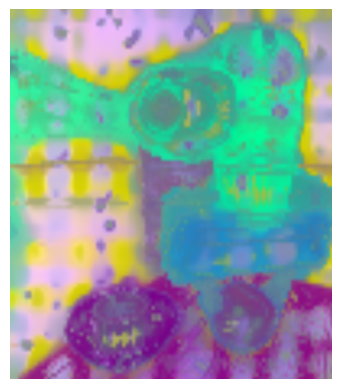

In [5]:
with torch.no_grad():
    img, H, W = load_image('../ctx/9.png', transform_size=1400)
    res = model(img)
    PCA_visualize(res, H, W)

In [ ]:
num = 24
column = 4
model = DINO(dino_name="dinov2", model_name='vitl14', layer=0).to('cuda')
for i in range(24):
    print(f'{i} / {num}')
    model.multilayers = [i]
    img, H, W = load_image('../ctx/7.png', transform_size=224)
    res = model(img)
    res = PCA_visualize(res, H, W, return_res=True)
    plt.subplot(num//column, column, i+1)
    plt.title(f'{i}')
    plt.imshow(res)
    plt.axis('off')


# Stable Diffusion

In [6]:
model = DIFT().to('cuda')

/home/vcc/miniconda3/envs/probe3d/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
num = 4
column = 2
for i in range(num):
    with torch.no_grad():
        print(f'{i} / {num}')
        model.multilayers = [i]
        img, H, W = load_image('../ctx/1.png', transform_size=1600)
        res = model(img)
        res = PCA_visualize(res, H, W, return_res=True)
        plt.subplot(num//column, column, i+1)
        plt.title(f'{i}')
        plt.imshow(res)
        plt.axis('off')


(1044, 908, 3)


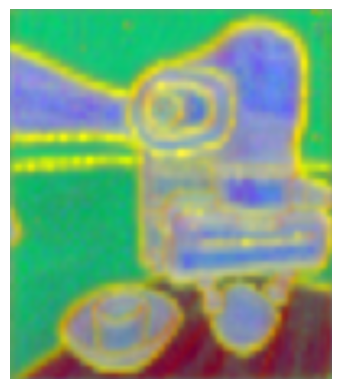

In [7]:
with torch.no_grad():
    img, H, W = load_image('../ctx/9.png', transform_size=1600)
    res = model(img)
    PCA_visualize(res, H, W)

In [9]:
model

NameError: name 'model' is not defined

# CLIP

In [2]:
model = CLIP().to('cuda')
len(model.visual.transformer.resblocks)

12

torch.Size([1, 768, 100, 100])
(1044, 908, 3)


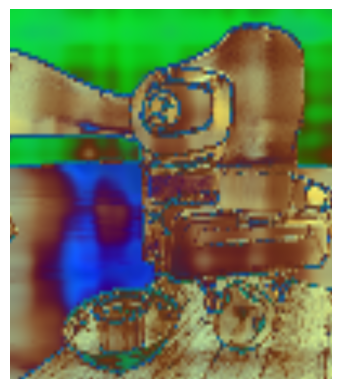

In [3]:
img, H, W = load_image('../ctx/9.png', transform_size=1600)
res = model(img)
print(res.shape)
PCA_visualize(res, H, W)

0 / 12
torch.Size([1, 768, 100, 100])
(896, 920, 3)
1 / 12
torch.Size([1, 768, 100, 100])
(896, 920, 3)
2 / 12
torch.Size([1, 768, 100, 100])
(896, 920, 3)
3 / 12
torch.Size([1, 768, 100, 100])
(896, 920, 3)
4 / 12
torch.Size([1, 768, 100, 100])
(896, 920, 3)
5 / 12
torch.Size([1, 768, 100, 100])
(896, 920, 3)
6 / 12
torch.Size([1, 768, 100, 100])
(896, 920, 3)
7 / 12
torch.Size([1, 768, 100, 100])
(896, 920, 3)
8 / 12
torch.Size([1, 768, 100, 100])
(896, 920, 3)
9 / 12
torch.Size([1, 768, 100, 100])
(896, 920, 3)
10 / 12
torch.Size([1, 768, 100, 100])
(896, 920, 3)
11 / 12
torch.Size([1, 768, 100, 100])
(896, 920, 3)


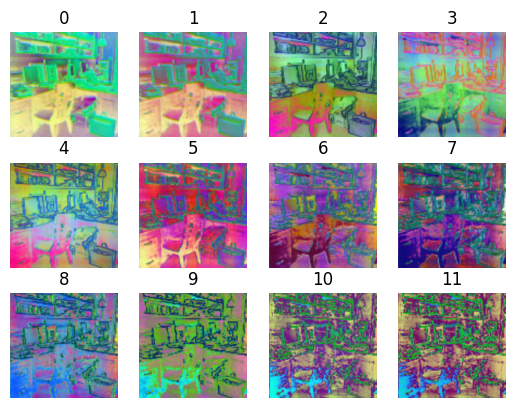

In [4]:
num = 12
column = 4
model = CLIP(layer=0).to('cuda')
for i in range(num):
    print(f'{i} / {num}')
    model.multilayers = [i]
    img, H, W = load_image('../ctx/3.png', transform_size=1600)
    res = model(img)
    print(res.shape)
    res = PCA_visualize(res, H, W, return_res=True)
    plt.subplot(num//column, column, i+1)
    plt.title(f'{i}')
    plt.imshow(res)
    plt.axis('off')


In [ ]:
type(res)

# RADIO

In [5]:
model = RADIO().to('cuda')
len(model.radio.model.blocks)

Using cache found in /home/vcc/.cache/torch/hub/NVlabs_RADIO_main


32

(1044, 908, 3)


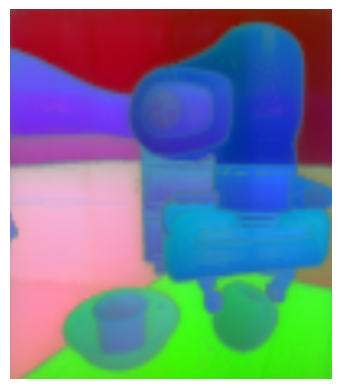

In [8]:
img, H, W = load_image('../ctx/9.png', transform_size=1600)
res = model(img)
PCA_visualize(res, H, W)

In [ ]:
num = 32
model = RADIO().to('cuda')
column = 6
for i in range(num):
    print(f'{i} / {num}')
    model.multilayers = [i]
    img, H, W = load_image('../ctx/1.png', transform_size=1024)
    res = model(img)
    res = PCA_visualize(res, H, W, return_res=True)
    plt.subplot(num//column+1, column, i+1)
    plt.title(f'{i}')
    plt.imshow(res)
    plt.axis('off')

In [9]:
model = model.cpu()

# SAM

In [2]:
model = SAM(arch="vit_h", device='cuda')
len(model.vit.blocks)

32

(1044, 908, 3)


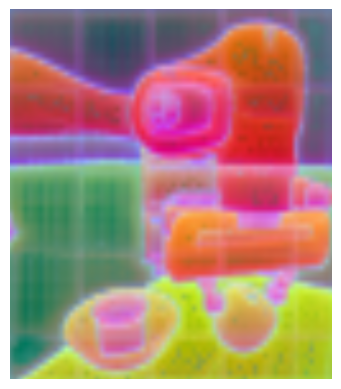

In [3]:
img, H, W = load_image('../ctx/9.png', transform_size=1024)
res = model(img)
PCA_visualize(res, H, W)

In [ ]:
num = 32
model = SAM(arch="vit_h", device='cuda', layer=0)
column = 8
for i in range(num):
    print(f'{i} / {num}')
    model.multilayers = [i]
    img, H, W = load_image('../ctx/7.png', transform_size=1024)
    res = model(img)
    res = PCA_visualize(res, H, W, return_res=True)
    plt.subplot(num//column, column, i+1)
    plt.title(f'{i}')
    plt.imshow(res)
    plt.axis('off')

# sense